In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
from utils.data import load_data, prepare_data
from utils.model import save_parameters

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
df = load_data('data/SP1.csv')
df.head()

Div        Date   Time    HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  \
0  SP1  16/08/2019  20:00  Ath Bilbao    Barcelona     1     0   H     0   
1  SP1  17/08/2019  16:00       Celta  Real Madrid     1     3   A     0   
2  SP1  17/08/2019  18:00    Valencia     Sociedad     1     1   D     0   
3  SP1  17/08/2019  19:00    Mallorca        Eibar     2     1   H     1   
4  SP1  17/08/2019  20:00     Leganes      Osasuna     0     1   A     0   

   HTAG  ... AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  \
0     0  ...     1.97  0.75      1.93      2.00   1.91   2.01     2.02   
1     1  ...     2.63  1.00      1.82      1.97   1.85   2.07     2.00   
2     0  ...     1.82 -0.75      1.94      1.99   1.92   2.00     1.96   
3     0  ...     1.66  0.00      2.11      1.82   2.09   1.83     2.12   
4     0  ...     1.46 -0.50      1.89      2.04   1.90   2.01     1.95   

   MaxCAHA  AvgCAHH  AvgCAHA  
0     2.03     1.91     1.98  
1     2.20     1.82     2.06  
2     2.12     1.89     2.00  
3     1.88     2.07     1.83  
4     2.06     1.90     1.99  

[5 rows x 105 columns]

In [4]:
df, team_categorical = prepare_data(df)
df.head()

HomeTeam     AwayTeam  HomeGoals  AwayGoals  HomeTeamId  AwayTeamId
0  Ath Bilbao    Barcelona          1          0           1           3
1       Celta  Real Madrid          1          3           5          14
2    Valencia     Sociedad          1          1          17          16
3    Mallorca        Eibar          2          1          12           6
4     Leganes      Osasuna          0          1          10          13

In [5]:
n_teams = len(df.HomeTeam.unique())
print(f'Total teams = {n_teams}')

Total teams = 20


## Model 1

No home advantage. 

attack_group_mean ~ Normal(0, 10)  
attack_group_sd ~ HalfCauchy(1)  
attack_team<sub>i</sub> ~ Normal(attack_group_mean, attack_group_sd)  

defense_group_mean ~ Normal(0, 10)  
defense_group_sd ~ HalfCauchy(1)  
defense_team<sub>i</sub> ~ Normal(defense_group_mean, defense_group_sd)  

log(home_rate<sub>i, j</sub>) = attack_team<sub>i</sub> - defense_team<sub>j</sub>  
home_goals<sub>i, j</sub> ~ Poisson(home_rate<sub>i, j</sub>)<br>
log(away_rate<sub>i, j</sub>) = attack_team<sub>j</sub> - defense_team<sub>i</sub>  
away_goals<sub>i, j</sub> ~ Poisson(away_rate<sub>i, j</sub>)

In [6]:
with pm.Model() as model_1:
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=10)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team = pm.Normal('attack_team', mu=attack_group_mean, sd=attack_group_sd, shape=n_teams)
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=10)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team = pm.Normal('defense_team', mu=defense_group_mean, sd=defense_group_sd, shape=n_teams)
    
    home_rate = pm.math.exp(attack_team[df.HomeTeamId] - defense_team[df.AwayTeamId])
    away_rate = pm.math.exp(attack_team[df.AwayTeamId] - defense_team[df.HomeTeamId])
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    trace_1 = pm.sample(1000, tune=1000)

/home/sagar/miniconda3/envs/bayesian/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/sagar/miniconda3/envs/bayesian/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sagar/miniconda3/envs/bayesian/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2264816130>,
      dtype=object)

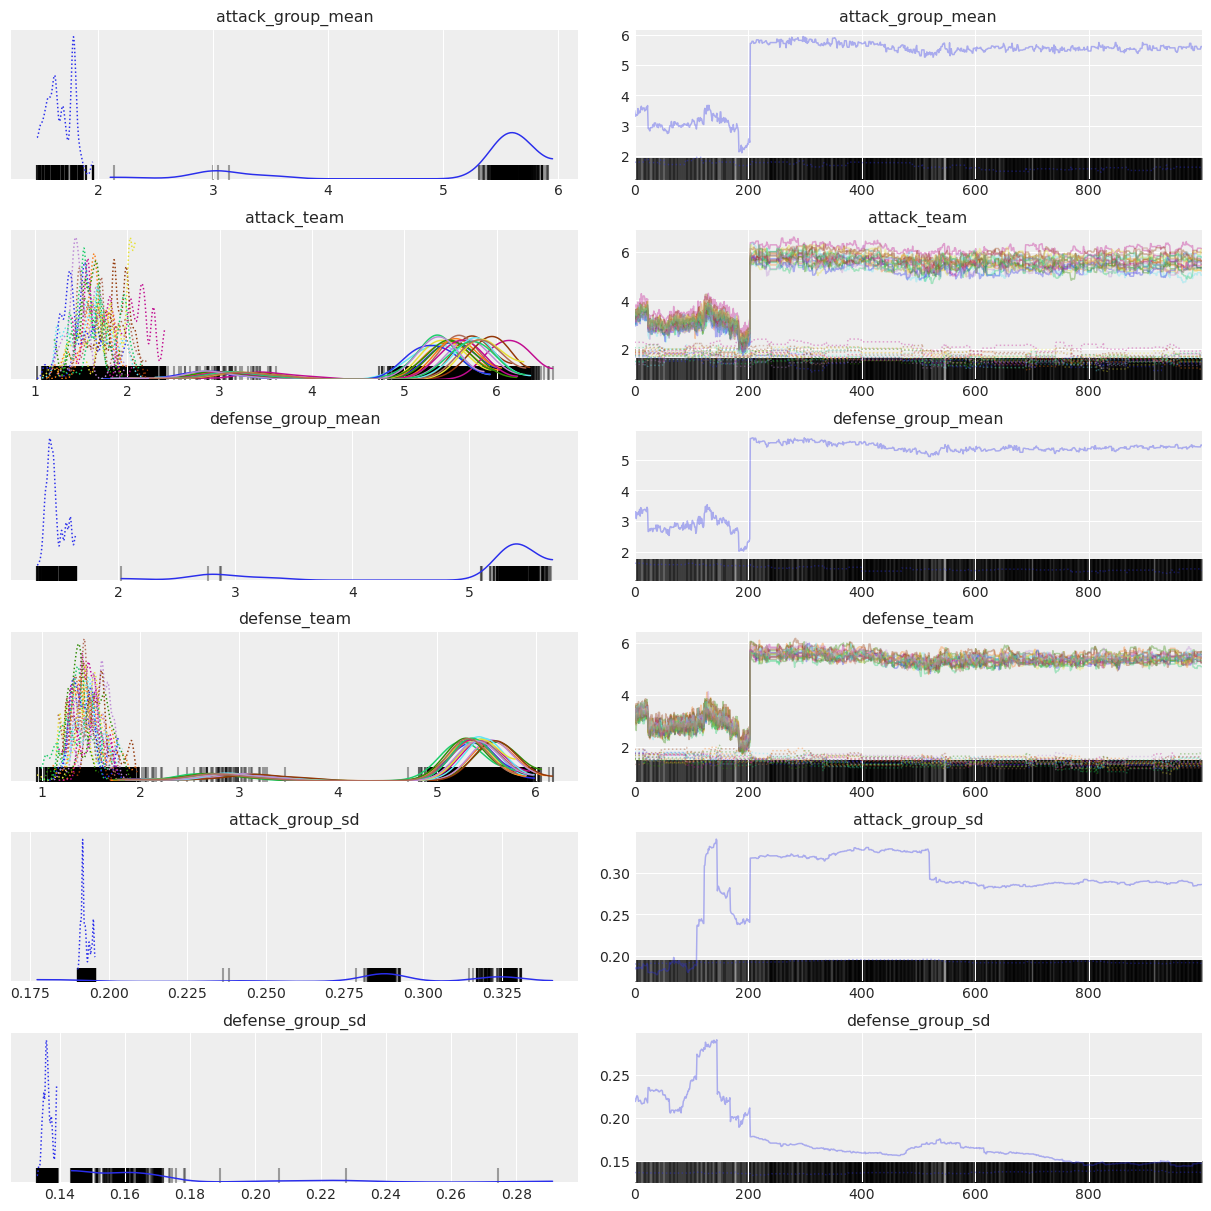

In [7]:
az.plot_trace(trace_1, compact=True)

* Too many divergences in model 1.
* Chains do not converge and mix properly.
* R hat statistic too large

Need to reparametrize the model

## Model 1 non-centered parametrization

In [8]:
dims = {
    'home_goals': ['match'],
    'away_goals': ['match'],
    'attack_team': ['team'],
    'defense_team': ['team']
}

In [9]:
with pm.Model() as model_1_nc:
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=10)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team_z = pm.Normal('attack_team_z', mu=0, sd=1, shape=n_teams)
    attack_team = pm.Deterministic('attack_team', attack_group_mean + attack_group_sd * attack_team_z)
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=10)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team_z = pm.Normal('defense_team_z', mu=0, sd=1, shape=n_teams)
    defense_team = pm.Deterministic('defense_team', defense_group_mean + defense_group_sd * defense_team_z)
    
    home_rate = pm.math.exp(attack_team[df.HomeTeamId] - defense_team[df.AwayTeamId])
    away_rate = pm.math.exp(attack_team[df.AwayTeamId] - defense_team[df.HomeTeamId])
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    
    trace_1_nc = pm.sample(1000, tune=1000)
    post_pred_1 = pm.sample_posterior_predictive(trace_1_nc)
    idata_1_nc = az.from_pymc3(trace_1_nc,
                              posterior_predictive=post_pred_1,
                              coords={'match': df.index, 'team': team_categorical.categories},
                              dims=dims)

/home/sagar/miniconda3/envs/bayesian/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sagar/miniconda3/envs/bayesian/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defense_team_z, defense_group_sd, defense_group_

In [10]:
save_parameters(trace_1_nc, idata_1_nc, 'model_1_nc')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f225cca3880>,
      dtype=object)

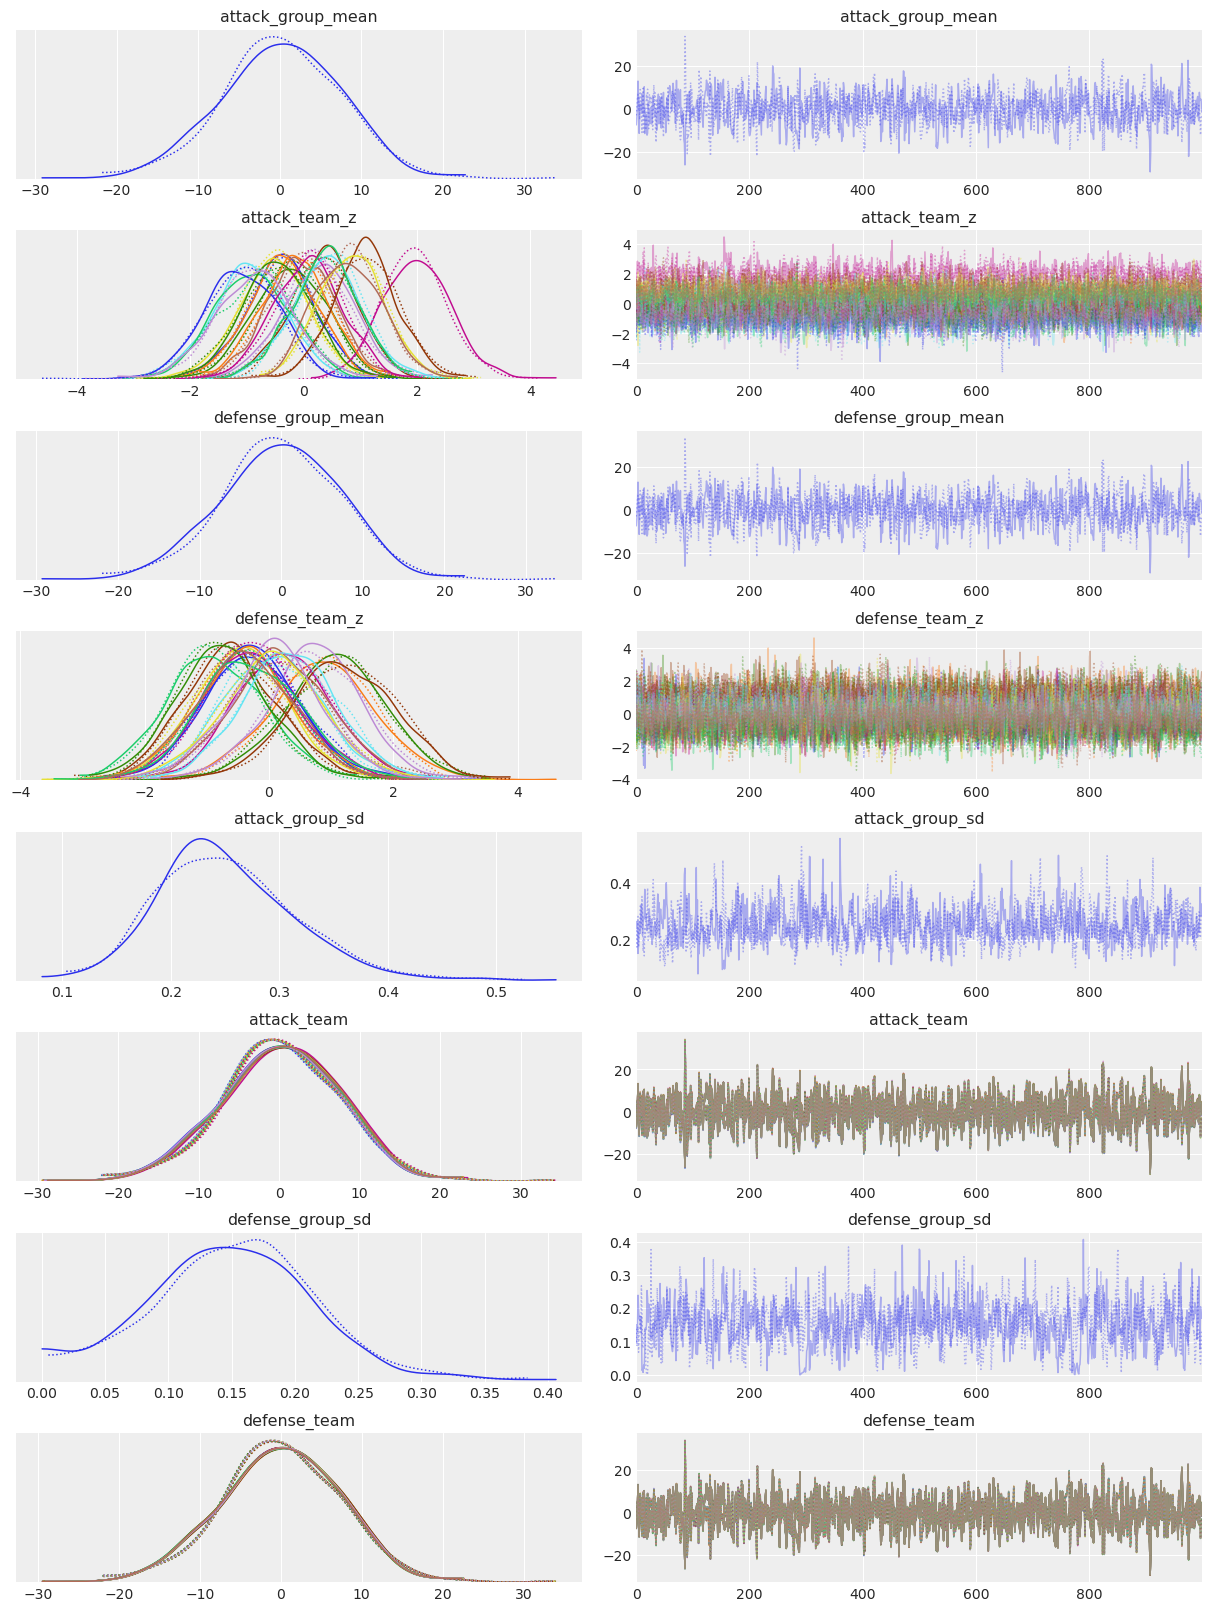

In [11]:
az.plot_trace(idata_1_nc, compact=True)

Text(0, 0.5, 'Density')

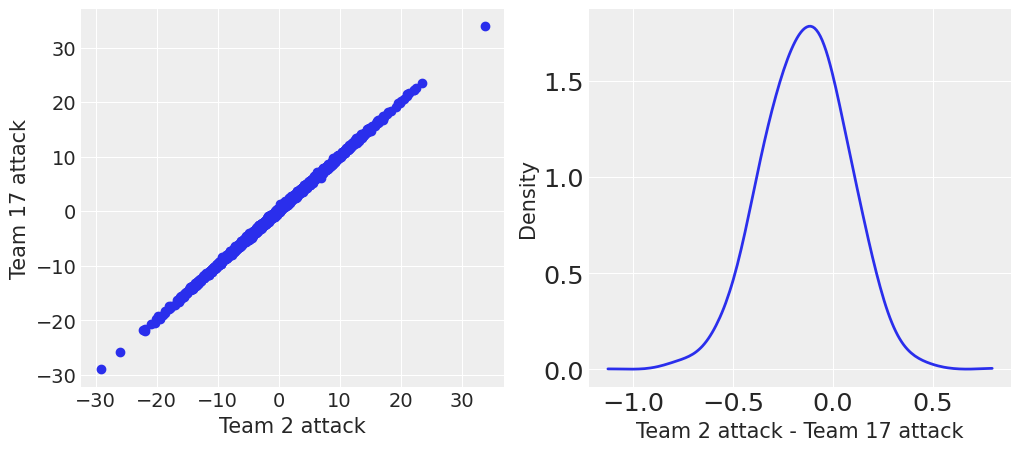

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(trace_1_nc['attack_team'][:, 2], trace_1_nc['attack_team'][:, 17], 'o')
axs[0].set_xlabel('Team 2 attack')
axs[0].set_ylabel('Team 17 attack')

az.plot_dist(trace_1_nc['attack_team'][:, 2] - trace_1_nc['attack_team'][:, 17], ax=axs[1])
axs[1].set_xlabel('Team 2 attack - Team 17 attack')
axs[1].set_ylabel('Density')

In [13]:
pm.trace_to_dataframe(trace_1_nc, varnames=['attack_team']).corr()

attack_team__0  attack_team__1  attack_team__2  \
attack_team__0         1.000000        0.999606        0.999625   
attack_team__1         0.999606        1.000000        0.999610   
attack_team__2         0.999625        0.999610        1.000000   
attack_team__3         0.999618        0.999623        0.999621   
attack_team__4         0.999613        0.999614        0.999623   
attack_team__5         0.999572        0.999580        0.999546   
attack_team__6         0.999642        0.999615        0.999600   
attack_team__7         0.999546        0.999570        0.999555   
attack_team__8         0.999604        0.999574        0.999608   
attack_team__9         0.999641        0.999659        0.999616   
attack_team__10        0.999593        0.999614        0.999567   
attack_team__11        0.999620        0.999649        0.999605   
attack_team__12        0.999623        0.999625        0.999640   
attack_team__13        0.999632        0.999617        0.999607   
attack_team__14        0.999610        0.999636        0.999610   
attack_team__15        0.999623        0.999620        0.999621   
attack_team__16        0.999623        0.999655        0.999625   
attack_team__17        0.999627        0.999610        0.999581   
attack_team__18        0.999566        0.999558        0.999526   
attack_team__19        0.999617        0.999625        0.999603   

                 attack_team__3  attack_team__4  attack_team__5  \
attack_team__0         0.999618        0.999613        0.999572   
attack_team__1         0.999623        0.999614        0.999580   
attack_team__2         0.999621        0.999623        0.999546   
attack_team__3         1.000000        0.999676        0.999515   
attack_team__4         0.999676        1.000000        0.999543   
attack_team__5         0.999515        0.999543        1.000000   
attack_team__6         0.999618        0.999631        0.999606   
attack_team__7         0.999525        0.999544        0.999514   
attack_team__8         0.999635        0.999635        0.999541   
attack_team__9         0.999631        0.999639        0.999575   
attack_team__10        0.999545        0.999555        0.999569   
attack_team__11        0.999635        0.999642        0.999555   
attack_team__12        0.999595        0.999603        0.999567   
attack_team__13        0.999645        0.999625        0.999576   
attack_team__14        0.999690        0.999661        0.999537   
attack_team__15        0.999674        0.999647        0.999548   
attack_team__16        0.999707        0.999648        0.999565   
attack_team__17        0.999665        0.999651        0.999561   
attack_team__18        0.999529        0.999542        0.999537   
attack_team__19        0.999712        0.999653        0.999544   

                 attack_team__6  attack_team__7  attack_team__8  \
attack_team__0         0.999642        0.999546        0.999604   
attack_team__1         0.999615        0.999570        0.999574   
attack_team__2         0.999600        0.999555        0.999608   
attack_team__3         0.999618        0.999525        0.999635   
attack_team__4         0.999631        0.999544        0.999635   
attack_team__5         0.999606        0.999514        0.999541   
attack_team__6         1.000000        0.999564        0.999628   
attack_team__7         0.999564        1.000000        0.999548   
attack_team__8         0.999628        0.999548        1.000000   
attack_team__9         0.999625        0.999552        0.999617   
attack_team__10        0.999592        0.999538        0.999553   
attack_team__11        0.999625        0.999566        0.999605   
attack_team__12        0.999626        0.999535        0.999582   
attack_team__13        0.999635        0.999565        0.999632   
attack_team__14        0.999619        0.999521        0.999639   
attack_team__15        0.999623        0.999556        0.999624   
attack_team__16        0.999629        0.999542        0.99963

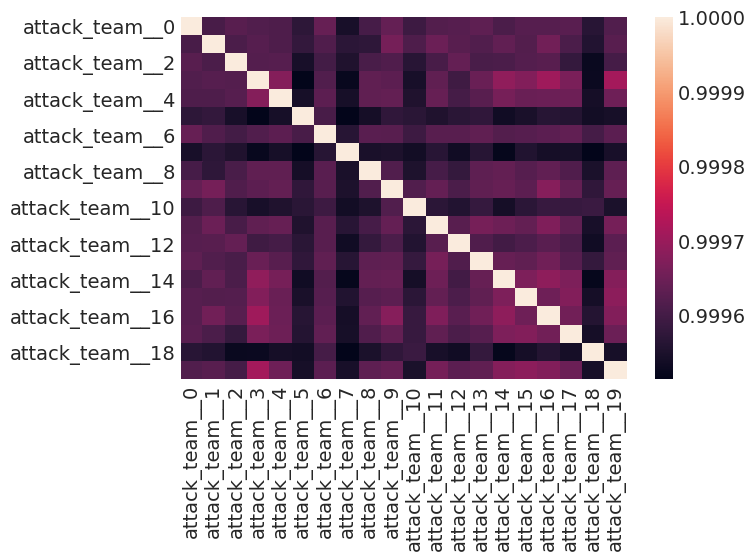

In [14]:
sns.heatmap(pm.trace_to_dataframe(trace_1_nc, varnames=['attack_team']).corr())

* Too much variance in parameter estimates.
* Model is unidentifiable. Adding any constant k to all the attack and defense parameters will lead to the same predictions
* Estimates are strongly correlated.
* Need to add some more constraints.

## Model 2

* No home team advantage.
* Add sum to one constraint on the attack and defense parameters of the teams.
* Non-centered parametrization

attack_group_mean ~ Normal(0, 10)  
attack_group_sd ~ HalfCauchy(1)  
attack_team<sub>i</sub> ~ Normal(attack_group_mean, attack_group_sd)  

defense_group_mean ~ Normal(0, 10)  
defense_group_sd ~ HalfCauchy(1)  
defense_team<sub>i</sub> ~ Normal(defense_group_mean, defense_group_sd)  

log(home_rate<sub>i, j</sub>) = attack_team<sub>i</sub> - defense_team<sub>j</sub>  
home_goals<sub>i, j</sub> ~ Poisson(home_rate<sub>i, j</sub>)<br>
log(away_rate<sub>i, j</sub>) = attack_team<sub>j</sub> - defense_team<sub>i</sub>  
away_goals<sub>i, j</sub> ~ Poisson(away_rate<sub>i, j</sub>)  

$\sum_{i=1}^{20} attackteam_i$ = 0  
$\sum_{i=1}^{20} defenseteam_i$ = 0

In [15]:
import theano.tensor as tt

In [18]:
with pm.Model() as model_2:
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=10)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team_z = pm.Normal('attack_team_z', mu=0, sd=1, shape=n_teams)
    attack_team_ = attack_group_mean + attack_group_sd * attack_team_z
    #attack_team = pm.Deterministic('attack_team', tt.concatenate([attack_team_, tt.stack(-tt.sum(attack_team_))]))
    attack_team = pm.Deterministic('attack_team', attack_team_ - tt.mean(attack_team_))
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=10)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team_z = pm.Normal('defense_team_z', mu=0, sd=1, shape=n_teams)
    defense_team_ = defense_group_mean + defense_group_sd * defense_team_z
    #defense_team = pm.Deterministic('defense_team', tt.concatenate([defense_team_, tt.stack(-tt.sum(defense_team_))]))
    defense_team = pm.Deterministic('defense_team', defense_team_ - tt.mean(defense_team_))
    
    home_rate = pm.math.exp(attack_team[df.HomeTeamId] - defense_team[df.AwayTeamId])
    away_rate = pm.math.exp(attack_team[df.AwayTeamId] - defense_team[df.HomeTeamId])
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    trace_2 = pm.sample(1000, tune=1000)
    post_pred_2 = pm.sample_posterior_predictive(trace_2)
    idata_2 = az.from_pymc3(trace_2,
                           posterior_predictive=post_pred_2,
                           coords={'match': df.index, 'team': team_categorical.categories},
                           dims=dims)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defense_team_z, defense_group_sd, defense_group_mean, attack_team_z, attack_group_sd, attack_group_mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:15<00:00, 255.22draws/s]
/home/sagar/miniconda3/envs/bayesian/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100%|██████████| 2000/2000 [00:05<00:00, 358.08it/s]


In [19]:
save_parameters(trace_2, idata_2, 'model_2')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22466c63d0>,
      dtype=object)

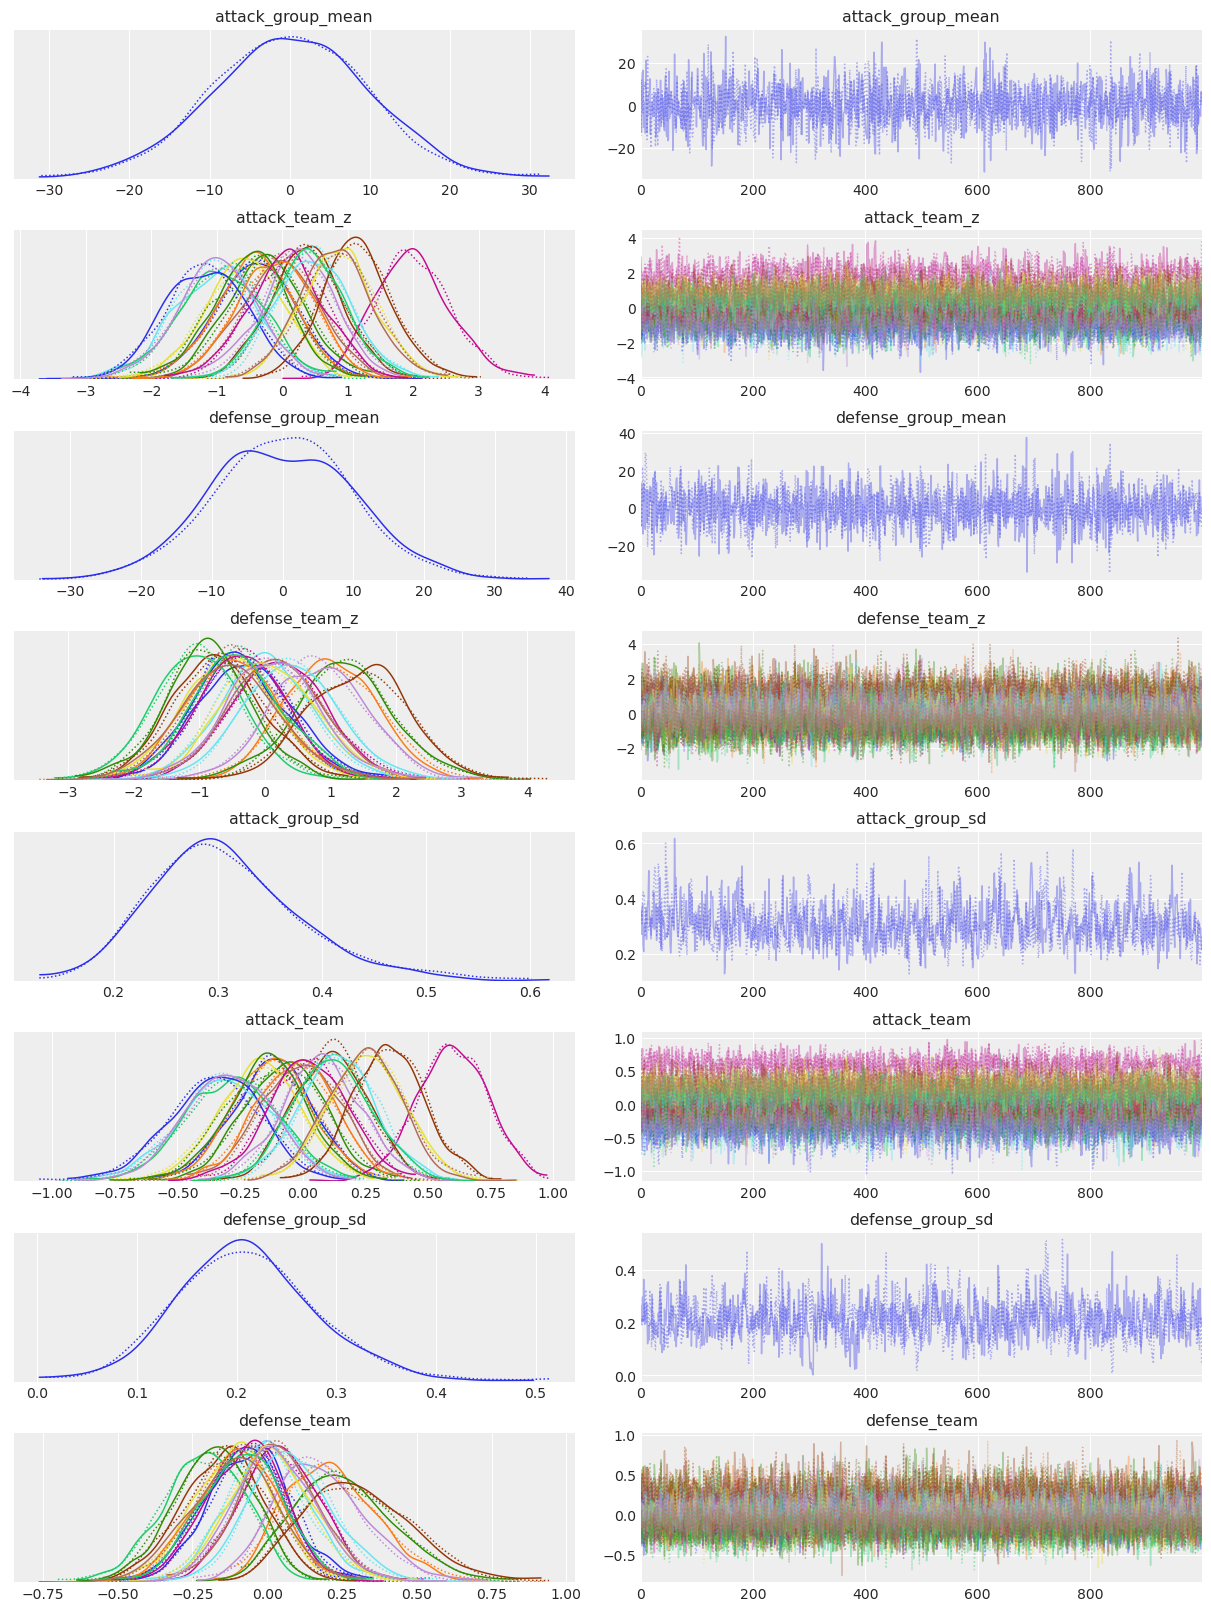

In [20]:
az.plot_trace(idata_2, compact=True)

In [22]:
az.summary(idata_2, var_names=['attack_group_mean', 'attack_group_sd', 'attack_team'],
           hdi_prob=0.89)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
attack_group_mean  0.060  9.711   -14.504     16.400      0.196    0.224   
attack_group_sd    0.308  0.072     0.199      0.418      0.003    0.002   
attack_team[0]    -0.122  0.161    -0.373      0.138      0.003    0.003   
attack_team[1]    -0.125  0.161    -0.360      0.144      0.003    0.003   
attack_team[2]    -0.075  0.163    -0.344      0.167      0.003    0.003   
attack_team[3]     0.597  0.139     0.389      0.836      0.003    0.002   
attack_team[4]     0.115  0.145    -0.100      0.360      0.003    0.003   
attack_team[5]    -0.310  0.181    -0.608     -0.038      0.004    0.003   
attack_team[6]    -0.173  0.166    -0.438      0.095      0.004    0.003   
attack_team[7]    -0.282  0.181    -0.565      0.006      0.004    0.003   
attack_team[8]     0.078  0.156    -0.173      0.331      0.003    0.003   
attack_team[9]    -0.008  0.158    -0.258      0.233      0.003    0.004   
attack_team[10]   -0.354  0.184    -0.622     -0.047      0.004    0.004   
attack_team[11]   -0.031  0.159    -0.265      0.232      0.003    0.003   
attack_team[12]   -0.146  0.164    -0.400      0.118      0.003    0.003   
attack_team[13]    0.023  0.156    -0.214      0.277      0.003    0.003   
attack_team[14]    0.346  0.141     0.118      0.564      0.003    0.002   
attack_team[15]    0.143  0.150    -0.102      0.382      0.003    0.003   
attack_team[16]    0.260  0.150     0.025      0.490      0.003    0.002   
attack_team[17]    0.116  0.154    -0.136      0.350      0.003    0.003   
attack_team[18]   -0.302  0.177    -0.568     -0.017      0.004    0.003   
attack_team[19]    0.249  0.148     0.008      0.473      0.003    0.002   

                   ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
attack_group_mean    2449.0   941.0    2449.0    1236.0    1.0  
attack_group_sd       704.0   702.0     722.0    1036.0    1.0  
attack_team[0]       2406.0  1513.0    2422.0    1494.0    1.0  
attack_team[1]       2866.0  1446.0    2884.0    1532.0    1.0  
attack_team[2]       2316.0  1167.0    2332.0    1553.0    1.0  
attack_team[3]       2007.0  2007.0    2032.0    1429.0    1.0  
attack_team[4]       2234.0  1678.0    2241.0    1396.0    1.0  
attack_team[5]       2315.0  1880.0    2318.0    1502.0    1.0  
attack_team[6]       2094.0  1289.0    2118.0    1184.0    1.0  
attack_team[7]       2394.0  2029.0    2403.0    1464.0    1.0  
attack_team[8]       2311.0  1254.0    2314.0    1307.0    1.0  
attack_team[9]       2644.0   913.0    2673.0    1525.0    1.0  
attack_team[10]      1692.0  1353.0    1757.0    1389.0    1.0  
attack_team[11]      2546.0  1033.0    2562.0    1458.0    1.0  
attack_team[12]      2343.0  1325.0    2376.0    1414.0    1.0  
attack_team[13]      2620.0  1049.0    2623.0    1605.0    1.0  
attack_team[14]      1900.0  1742.0    1906.0    1322.0    1.0  
attack_team[15]      2407.0  1594.0    2400.0    1487.0    1.0  
attack_team[16]      2841.0  2579.0    2806.0    1445.0    1.0  
attack_team[17]      2273.0  1268.0    2269.0    1229.0    1.0  
attack_team[18]      2044.0  1469.0    2125.0    1332.0    1.0  
attack_team[19]      2354.0  2038.0    2341.0    1471.0    1.0

In [24]:
az.summary(idata_2, var_names=['defense_group_mean', 'defense_group_sd', 'defense_team'],
           hdi_prob=0.89)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
defense_group_mean  0.059  9.876   -15.699     15.359      0.203    0.242   
defense_group_sd    0.211  0.071     0.106      0.327      0.003    0.002   
defense_team[0]    -0.058  0.135    -0.295      0.130      0.003    0.003   
defense_team[1]     0.217  0.154    -0.032      0.441      0.004    0.003   
defense_team[2]     0.259  0.166    -0.015      0.504      0.004    0.003   
defense_team[3]     0.045  0.137    -0.177      0.249      0.003    0.003   
defense_team[4]    -0.146  0.137    -0.371      0.065      0.003    0.002   
defense_team[5]     0.001  0.135    -0.224      0.205      0.003    0.003   
defense_team[6]    -0.113  0.136    -0.319      0.109      0.003    0.002   
defense_team[7]    -0.213  0.138    -0.437     -0.005      0.003    0.002   
defense_team[8]     0.175  0.150    -0.049      0.420      0.004    0.003   
defense_team[9]     0.037  0.134    -0.176      0.253      0.003    0.003   
defense_team[10]   -0.085  0.132    -0.295      0.116      0.003    0.002   
defense_team[11]   -0.095  0.134    -0.317      0.105      0.003    0.002   
defense_team[12]   -0.181  0.132    -0.399      0.016      0.003    0.002   
defense_team[13]   -0.073  0.129    -0.288      0.111      0.003    0.002   
defense_team[14]    0.305  0.180     0.017      0.570      0.005    0.003   
defense_team[15]    0.082  0.140    -0.135      0.300      0.003    0.003   
defense_team[16]    0.009  0.138    -0.194      0.242      0.003    0.003   
defense_team[17]   -0.085  0.137    -0.294      0.133      0.003    0.002   
defense_team[18]    0.029  0.137    -0.205      0.230      0.003    0.003   
defense_team[19]   -0.110  0.141    -0.329      0.115      0.003    0.003   

                    ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
defense_group_mean    2375.0   833.0    2371.0    1319.0    1.0  
defense_group_sd       704.0   704.0     696.0     790.0    1.0  
defense_team[0]       2459.0  1230.0    2439.0    1781.0    1.0  
defense_team[1]       1681.0  1601.0    1689.0    1685.0    1.0  
defense_team[2]       1595.0  1595.0    1529.0    1157.0    1.0  
defense_team[3]       2539.0  1111.0    2586.0    1666.0    1.0  
defense_team[4]       1823.0  1738.0    1797.0    1552.0    1.0  
defense_team[5]       2307.0  1134.0    2373.0    1584.0    1.0  
defense_team[6]       2198.0  1871.0    2130.0    1423.0    1.0  
defense_team[7]       1581.0  1581.0    1568.0    1463.0    1.0  
defense_team[8]       1731.0  1679.0    1735.0    1692.0    1.0  
defense_team[9]       2502.0  1132.0    2511.0    1537.0    1.0  
defense_team[10]      2397.0  1609.0    2405.0    1629.0    1.0  
defense_team[11]      2123.0  1476.0    2141.0    1551.0    1.0  
defense_team[12]      1928.0  1928.0    1874.0    1509.0    1.0  
defense_team[13]      2080.0  1399.0    2059.0    1591.0    1.0  
defense_team[14]      1325.0  1325.0    1265.0     976.0    1.0  
defense_team[15]      2081.0  1375.0    2064.0    1727.0    1.0  
defense_team[16]      2860.0  1018.0    2849.0    1569.0    1.0  
defense_team[17]      2294.0  1559.0    2248.0    1238.0    1.0  
defense_team[18]      2537.0  1195.0    2559.0    1541.0    1.0  
defense_team[19]      2391.0  1458.0    2326.0    1438.0    1.0

Text(0, 0.5, 'Density')

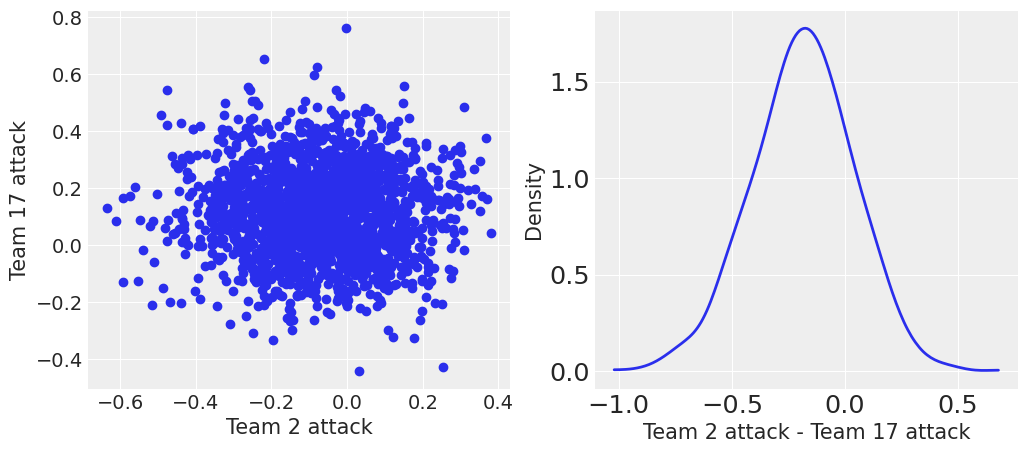

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(trace_2['attack_team'][:, 2], trace_2['attack_team'][:, 17], 'o')
axs[0].set_xlabel('Team 2 attack')
axs[0].set_ylabel('Team 17 attack')

az.plot_dist(trace_2['attack_team'][:, 2] - trace_2['attack_team'][:, 17], ax=axs[1])
axs[1].set_xlabel('Team 2 attack - Team 17 attack')
axs[1].set_ylabel('Density')

In [26]:
pm.trace_to_dataframe(trace_2, varnames=['attack_team']).corr()

attack_team__0  attack_team__1  attack_team__2  \
attack_team__0         1.000000       -0.045590       -0.047212   
attack_team__1        -0.045590        1.000000       -0.139201   
attack_team__2        -0.047212       -0.139201        1.000000   
attack_team__3        -0.053889       -0.044760       -0.075852   
attack_team__4        -0.088942       -0.109731       -0.037328   
attack_team__5        -0.079475       -0.026100       -0.089324   
attack_team__6        -0.067060       -0.029612       -0.030360   
attack_team__7        -0.037417       -0.082534       -0.112172   
attack_team__8        -0.056986       -0.102475       -0.051831   
attack_team__9        -0.049849       -0.074312        0.037181   
attack_team__10       -0.052146       -0.010917       -0.058008   
attack_team__11       -0.048521       -0.069897       -0.053622   
attack_team__12       -0.052151       -0.003270       -0.016191   
attack_team__13       -0.020632       -0.079164       -0.054892   
attack_team__14       -0.105580       -0.087905       -0.019525   
attack_team__15       -0.031402       -0.060627       -0.074333   
attack_team__16       -0.064189       -0.005409       -0.074924   
attack_team__17       -0.121607       -0.030537       -0.005422   
attack_team__18        0.020369       -0.002217       -0.050993   
attack_team__19       -0.018354       -0.020497       -0.052364   

                 attack_team__3  attack_team__4  attack_team__5  \
attack_team__0        -0.053889       -0.088942       -0.079475   
attack_team__1        -0.044760       -0.109731       -0.026100   
attack_team__2        -0.075852       -0.037328       -0.089324   
attack_team__3         1.000000        0.002137       -0.103826   
attack_team__4         0.002137        1.000000       -0.060514   
attack_team__5        -0.103826       -0.060514        1.000000   
attack_team__6        -0.097234       -0.071515       -0.070617   
attack_team__7        -0.111579       -0.078693        0.040955   
attack_team__8        -0.018588        0.033296       -0.102231   
attack_team__9        -0.057180       -0.043109       -0.002509   
attack_team__10       -0.156798       -0.097882        0.029998   
attack_team__11       -0.024776       -0.023380       -0.040222   
attack_team__12       -0.104109       -0.012615       -0.047507   
attack_team__13       -0.064686       -0.050136       -0.104592   
attack_team__14        0.121635       -0.015561       -0.121905   
attack_team__15        0.044013       -0.047412       -0.075328   
attack_team__16        0.039374       -0.066921       -0.145845   
attack_team__17        0.026679       -0.005474       -0.091390   
attack_team__18       -0.129095       -0.089590        0.005505   
attack_team__19        0.029665       -0.005155       -0.114720   

                 attack_team__6  attack_team__7  attack_team__8  \
attack_team__0        -0.067060       -0.037417       -0.056986   
attack_team__1        -0.029612       -0.082534       -0.102475   
attack_team__2        -0.030360       -0.112172       -0.051831   
attack_team__3        -0.097234       -0.111579       -0.018588   
attack_team__4        -0.071515       -0.078693        0.033296   
attack_team__5        -0.070617        0.040955       -0.102231   
attack_team__6         1.000000        0.006329       -0.113441   
attack_team__7         0.006329        1.000000       -0.064913   
attack_team__8        -0.113441       -0.064913        1.000000   
attack_team__9        -0.045087       -0.091531       -0.048849   
attack_team__10       -0.052863       -0.019140       -0.051004   
attack_team__11       -0.061889       -0.089812       -0.082625   
attack_team__12       -0.045865       -0.031544       -0.062243   
attack_team__13       -0.007846       -0.073544       -0.078516   
attack_team__14       -0.080297       -0.104070        0.048253   
attack_team__15       -0.017816       -0.078685       -0.018750   
attack_team__16       -0.031261       -0.058957       -0.02173

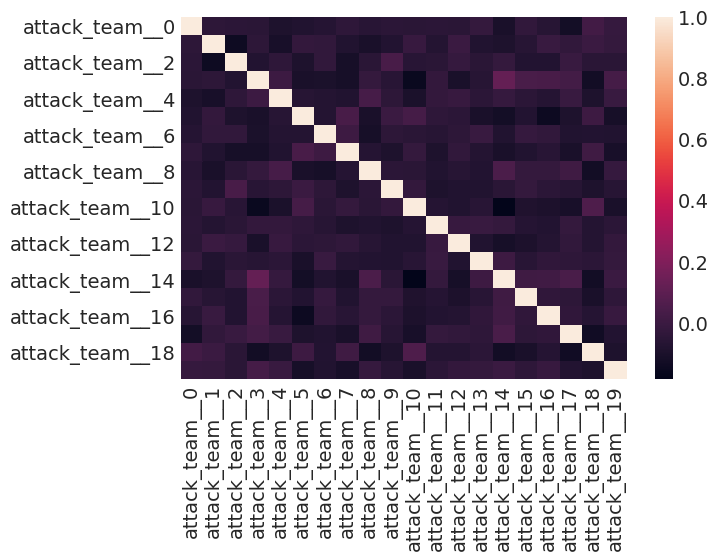

In [27]:
sns.heatmap(pm.trace_to_dataframe(trace_2, varnames=['attack_team']).corr())

* The strong correlation between estimates for each team is gone.
* The model is identifiable.
* The distribution of difference between the 2 teams seems to be similar for model 1 with non-centered parametrization and model 2 but the correlation between the 2 teams' estimates is removed.
* Note that the color bar is different for model 1 and model 2 correlation heatmaps.

## Model 3

* Equal home team advantage for each team.
* Sum to one constraint on the attack and defense parameters of the teams.
* Non-centered parametrization

attack_group_mean ~ Normal(0, 10)  
attack_group_sd ~ HalfCauchy(1)  
attack_team<sub>i</sub> ~ Normal(attack_group_mean, attack_group_sd)  

defense_group_mean ~ Normal(0, 10)  
defense_group_sd ~ HalfCauchy(1)  
defense_team<sub>i</sub> ~ Normal(defense_group_mean, defense_group_sd)  

home_advantage ~ Normal(0, 1)

log(home_rate<sub>i, j</sub>) = home_advantage + attack_team<sub>i</sub> - defense_team<sub>j</sub>  
home_goals<sub>i, j</sub> ~ Poisson(home_rate<sub>i, j</sub>)<br>
log(away_rate<sub>i, j</sub>) = attack_team<sub>j</sub> - defense_team<sub>i</sub>  
away_goals<sub>i, j</sub> ~ Poisson(away_rate<sub>i, j</sub>)  

$\sum_{i=1}^{20} attackteam_i$ = 0  
$\sum_{i=1}^{20} defenseteam_i$ = 0

In [28]:
with pm.Model() as model_3:
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=10)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team_z = pm.Normal('attack_team_z', mu=0, sd=1, shape=n_teams)
    attack_team_ = attack_group_mean + attack_group_sd * attack_team_z
    attack_team = pm.Deterministic('attack_team', attack_team_ - tt.mean(attack_team_))
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=10)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team_z = pm.Normal('defense_team_z', mu=0, sd=1, shape=n_teams)
    defense_team_ = defense_group_mean + defense_group_sd * defense_team_z
    defense_team = pm.Deterministic('defense_team', defense_team_ - tt.mean(defense_team_))
    
    home_advantage = pm.Normal('home_advantage', mu=0, sd=1)
    
    home_rate = pm.math.exp(home_advantage + attack_team[df.HomeTeamId] - defense_team[df.AwayTeamId])
    away_rate = pm.math.exp(attack_team[df.AwayTeamId] - defense_team[df.HomeTeamId])
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    trace_3 = pm.sample(1000, tune=1000)
    post_pred_3 = pm.sample_posterior_predictive(trace_3)
    idata_3 = az.from_pymc3(trace_3,
                           posterior_predictive=post_pred_3,
                           coords={'match': df.index, 'team': team_categorical.categories},
                           dims=dims)

/home/sagar/miniconda3/envs/bayesian/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sagar/miniconda3/envs/bayesian/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [home_advantage, defense_team_z, defense_group_sd

In [29]:
save_parameters(trace_3, idata_3, 'model_3')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2246101f70>,
      dtype=object)

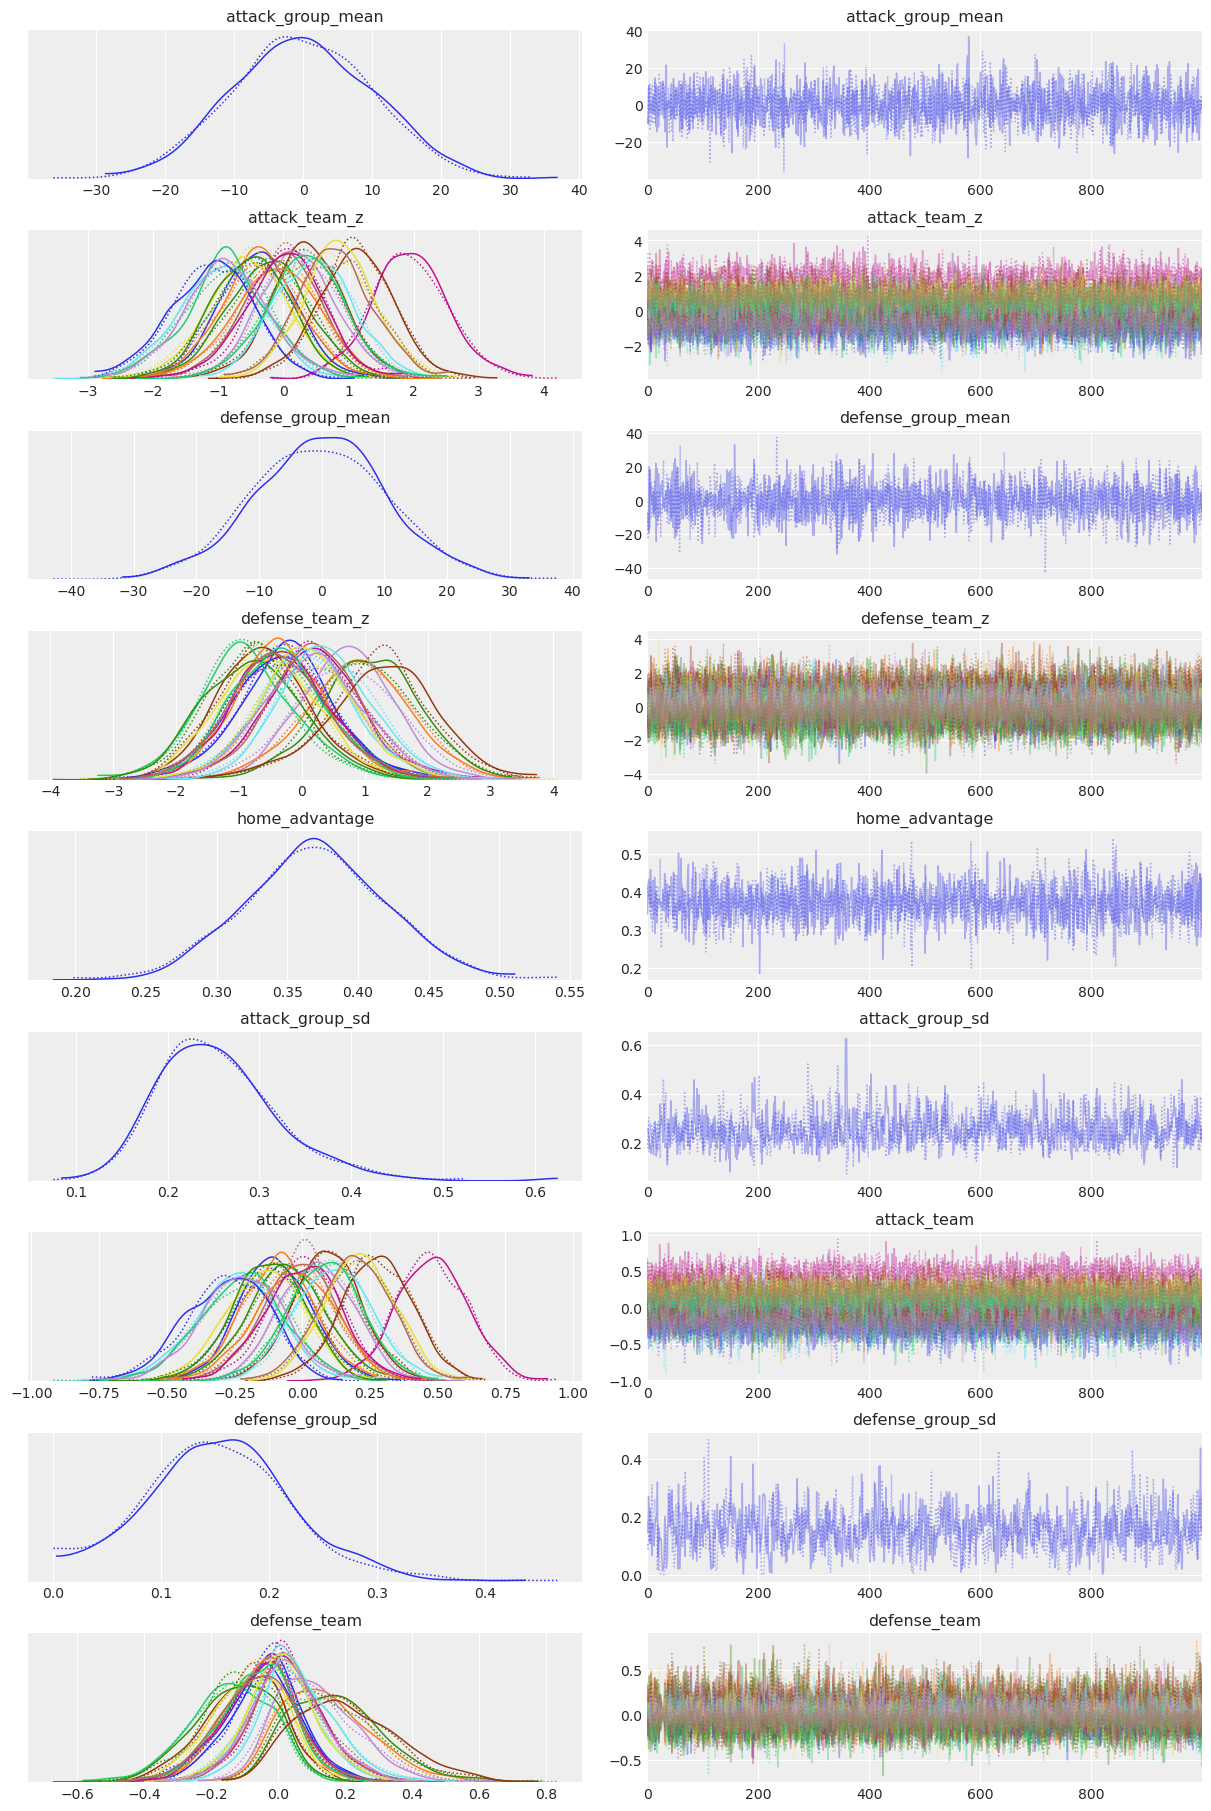

In [30]:
az.plot_trace(idata_3, compact=True)

In [32]:
az.summary(idata_3, var_names=['attack_group_mean', 'attack_group_sd', 'attack_team'], hdi_prob=0.89)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
attack_group_mean -0.103  9.996   -16.054     15.717      0.162    0.246   
attack_group_sd    0.255  0.065     0.151      0.347      0.002    0.002   
attack_team[0]    -0.104  0.139    -0.326      0.103      0.002    0.003   
attack_team[1]    -0.091  0.138    -0.307      0.138      0.003    0.003   
attack_team[2]    -0.060  0.144    -0.300      0.155      0.003    0.003   
attack_team[3]     0.478  0.130     0.293      0.703      0.003    0.002   
attack_team[4]     0.088  0.129    -0.121      0.288      0.003    0.003   
attack_team[5]    -0.244  0.157    -0.504     -0.010      0.003    0.003   
attack_team[6]    -0.137  0.143    -0.351      0.098      0.002    0.003   
attack_team[7]    -0.220  0.159    -0.466      0.027      0.003    0.003   
attack_team[8]     0.056  0.135    -0.133      0.290      0.002    0.003   
attack_team[9]    -0.007  0.134    -0.211      0.221      0.002    0.004   
attack_team[10]   -0.277  0.153    -0.524     -0.046      0.003    0.002   
attack_team[11]   -0.027  0.144    -0.249      0.204      0.002    0.004   
attack_team[12]   -0.123  0.139    -0.338      0.094      0.002    0.002   
attack_team[13]    0.006  0.137    -0.225      0.212      0.003    0.003   
attack_team[14]    0.277  0.130     0.075      0.484      0.003    0.002   
attack_team[15]    0.115  0.138    -0.100      0.333      0.002    0.003   
attack_team[16]    0.211  0.131    -0.003      0.407      0.002    0.002   
attack_team[17]    0.081  0.134    -0.142      0.284      0.002    0.003   
attack_team[18]   -0.222  0.155    -0.465      0.026      0.003    0.002   
attack_team[19]    0.199  0.132     0.002      0.411      0.002    0.002   

                   ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
attack_group_mean    3827.0   825.0    3824.0    1277.0   1.00  
attack_group_sd       775.0   775.0     781.0    1364.0   1.00  
attack_team[0]       3414.0  1411.0    3382.0    1273.0   1.01  
attack_team[1]       2781.0  1295.0    2810.0    1645.0   1.00  
attack_team[2]       3046.0  1015.0    3057.0    1279.0   1.00  
attack_team[3]       1819.0  1819.0    1797.0    1230.0   1.00  
attack_team[4]       2654.0  1272.0    2806.0    1230.0   1.00  
attack_team[5]       3161.0  1830.0    3261.0    1535.0   1.00  
attack_team[6]       3549.0  1523.0    3679.0    1589.0   1.00  
attack_team[7]       3202.0  1916.0    3309.0    1603.0   1.00  
attack_team[8]       2941.0  1154.0    2969.0    1321.0   1.00  
attack_team[9]       3339.0   614.0    3339.0    1373.0   1.01  
attack_team[10]      2513.0  1897.0    2581.0    1469.0   1.00  
attack_team[11]      3714.0   774.0    3763.0    1347.0   1.00  
attack_team[12]      3516.0  1635.0    3542.0    1629.0   1.00  
attack_team[13]      3014.0   871.0    3039.0    1580.0   1.00  
attack_team[14]      2334.0  2334.0    2384.0    1258.0   1.00  
attack_team[15]      3290.0  1433.0    3309.0    1225.0   1.00  
attack_team[16]      3214.0  2478.0    3224.0    1588.0   1.00  
attack_team[17]      3411.0  1345.0    3412.0    1643.0   1.00  
attack_team[18]      2391.0  1980.0    2355.0    1446.0   1.00  
attack_team[19]      3025.0  2324.0    3035.0    1636.0   1.00

In [33]:
az.summary(idata_3, var_names=['defense_group_mean', 'defense_group_sd', 'defense_team'], hdi_prob=0.89)

mean      sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
defense_group_mean -0.207  10.448   -16.834     15.974      0.172    0.246   
defense_group_sd    0.154   0.069     0.032      0.253      0.003    0.002   
defense_team[0]    -0.038   0.107    -0.213      0.121      0.002    0.002   
defense_team[1]     0.144   0.134    -0.054      0.338      0.003    0.003   
defense_team[2]     0.169   0.142    -0.040      0.384      0.004    0.003   
defense_team[3]     0.030   0.109    -0.136      0.211      0.002    0.002   
defense_team[4]    -0.100   0.114    -0.285      0.075      0.002    0.002   
defense_team[5]     0.010   0.108    -0.162      0.187      0.002    0.003   
defense_team[6]    -0.083   0.109    -0.261      0.079      0.002    0.002   
defense_team[7]    -0.143   0.121    -0.330      0.039      0.003    0.002   
defense_team[8]     0.113   0.125    -0.068      0.308      0.003    0.002   
defense_team[9]     0.027   0.112    -0.148      0.212      0.002    0.002   
defense_team[10]   -0.057   0.116    -0.232      0.137      0.002    0.002   
defense_team[11]   -0.059   0.107    -0.230      0.094      0.002    0.002   
defense_team[12]   -0.125   0.118    -0.317      0.045      0.003    0.002   
defense_team[13]   -0.055   0.110    -0.242      0.109      0.002    0.002   
defense_team[14]    0.199   0.150    -0.020      0.434      0.004    0.003   
defense_team[15]    0.059   0.115    -0.115      0.245      0.002    0.002   
defense_team[16]    0.011   0.108    -0.168      0.180      0.002    0.002   
defense_team[17]   -0.064   0.112    -0.254      0.093      0.002    0.002   
defense_team[18]    0.024   0.109    -0.143      0.204      0.002    0.002   
defense_team[19]   -0.062   0.115    -0.241      0.116      0.002    0.002   

                    ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
defense_group_mean    3686.0   902.0    3687.0    1505.0    1.0  
defense_group_sd       666.0   666.0     634.0     619.0    1.0  
defense_team[0]       2704.0  1114.0    2705.0    1632.0    1.0  
defense_team[1]       1786.0  1415.0    1871.0    1609.0    1.0  
defense_team[2]       1392.0  1367.0    1442.0    1502.0    1.0  
defense_team[3]       3157.0  1072.0    3199.0    1589.0    1.0  
defense_team[4]       2152.0  1741.0    2128.0    1574.0    1.0  
defense_team[5]       3869.0   877.0    4013.0    1473.0    1.0  
defense_team[6]       2326.0  1591.0    2317.0    1639.0    1.0  
defense_team[7]       1692.0  1692.0    1641.0    1187.0    1.0  
defense_team[8]       1870.0  1633.0    1852.0    1331.0    1.0  
defense_team[9]       3962.0  1133.0    4051.0    1685.0    1.0  
defense_team[10]      2579.0  1423.0    2603.0    1585.0    1.0  
defense_team[11]      2463.0  1284.0    2486.0    1597.0    1.0  
defense_team[12]      1517.0  1408.0    1495.0    1493.0    1.0  
defense_team[13]      3086.0  1193.0    3165.0    1481.0    1.0  
defense_team[14]      1403.0  1403.0    1335.0    1306.0    1.0  
defense_team[15]      3039.0  1109.0    3040.0    1514.0    1.0  
defense_team[16]      3802.0  1433.0    3895.0    1879.0    1.0  
defense_team[17]      2528.0  1232.0    2542.0    1251.0    1.0  
defense_team[18]      3495.0  1062.0    3541.0    1519.0    1.0  
defense_team[19]      2813.0  1382.0    2765.0    1551.0    1.0

In [36]:
az.summary(idata_3, var_names=['home_advantage'], hdi_prob=0.89)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
home_advantage  0.37  0.05     0.282       0.44      0.001    0.001    3423.0   

                ess_sd  ess_bulk  ess_tail  r_hat  
home_advantage  3339.0    3418.0    1239.0    1.0

In [37]:
home_adv = np.exp(az.summary(idata_3, var_names=['home_advantage'], hdi_prob=0.89).iloc[0, 2: 4])
print(f'{home_adv[0]} to {home_adv[1]} times more goals for the home team.')

1.3257787199867919 to 1.552707218511336 times more goals for the home team.
